In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ephem
import math
from datetime import timedelta
import matplotlib.dates as mdates

from datetime import datetime
from dateutil.relativedelta import relativedelta


### Read in the shadow dat
import glob



In [2]:
def calculate_solar_cos_zenith(datetime_obj):
    observer = ephem.Observer()
    latitude  = 38.980762    # ERW
    longitude = -107.005017  # ERW
    observer.lat = str(latitude)
    observer.lon = str(longitude)
    observer.date = datetime_obj

    sun = ephem.Sun(observer)
    solar_altitude = sun.alt

    # Calculate zenith angle (90 degrees - solar altitude)
    zenith_angle = math.pi / 2.0 - solar_altitude
    # Calculate cosine of zenith angle
    cos_zenith = math.cos(zenith_angle)

    return cos_zenith

In [3]:
rad_notes = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/intern_radiometer_notes.csv", parse_dates=True, index_col=0)

In [4]:
rad_notes_1h = rad_notes.resample("1h").ffill()

In [5]:
bad_dates = rad_notes_1h.index[rad_notes_1h.CAMSKYRAD.isin(['SC'])]
bad_dates = pd.DataFrame([pd.to_datetime(x) for x in bad_dates])[0]

In [6]:
len(bad_dates)/24

24.0

In [7]:
# print(len(bad_dates)/len((master_df)) * 100)
# rad_notes_1h.CAMSKYRAD.unique()

#### the purpose of this notebook is to compare different radiation estimates

In [8]:
master_df = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/master_df_sail_cre.csv", index_col=0, parse_dates=True)                        

In [9]:
master_df['suli_qaqc'] = rad_notes_1h.CAMSKYRAD

In [10]:
swdcdf = pd.read_csv("/global/homes/r/rudisill/gshare/sail_data_will/rrtmg/rrtmgClearSkySW_and_M1Obs_SailPeriod_all_o3_ceresAer_0611.csv", parse_dates=True, index_col=0)
#swdcdf = pd.read_csv("/global/homes/r/rudisill/gshare/sail_data_will/rrtmg/rrtmgClearSkySW_and_M1Obs_SailPeriod_all_o3_ceresAer_0509.csv", parse_dates=True, index_col=0)

In [11]:
swdcdf17 = pd.read_csv("/global/homes/r/rudisill/gshare/sail_data_will/rrtmg/rrtmgClearSkySW_and_M1Obs_SailPeriod_all_o3_ceresAer_0718.csv", parse_dates=True, index_col=0)
swdcdf172=pd.read_csv("~/gshare2/will_data/crf_files/rrtmgClearSkySW_and_M1Obs_SailPeriod_all_o3_ceresAer_0718_czaadj.csv", index_col=0, parse_dates=True)



In [12]:
master_df['rrtmg_swd_clear'] = swdcdf172.swd.reindex(master_df.index)

In [13]:
# #qcrad = xr.open_mfdataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/qcrad/*cdf")
# diffuse_hemisph = qcrad.down_short_diffuse_hemisp.where(qcrad.qc_down_short_diffuse_hemisp==0).to_pandas().resample("1h").mean()
# dir_normal = qcrad.short_direct_normal.where(qcrad.qc_short_direct_normal==0).to_pandas().resample("1h").mean()
# dsw_alt = master_df.cza * dir_normal + diffuse_hemisph
# master_df['qcrad_swd2'] = dsw_alt

In [14]:
kolias = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/kollias/cbh_kolias2.nc").to_pandas()
cloud_present_kolias = kolias.copy()
cloud_present_kolias[cloud_present_kolias == -1] = 0
cloud_present_kolias[cloud_present_kolias > 0] = 1


kolias_lt_4000 = kolias.where(kolias < 6000)
kolias_lt_4000.fillna(-1, inplace=True)
cloud_present_kolias_lt_4000 = kolias_lt_4000.copy()
cloud_present_kolias_lt_4000[cloud_present_kolias_lt_4000 == -1] = 0
cloud_present_kolias_lt_4000[cloud_present_kolias_lt_4000 > 0] = 1

master_df['cloud_present'] = cloud_present_kolias_lt_4000.resample("1h").mean().reindex(master_df.index) * 100

In [15]:
ceresds = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/ceres/CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4.1_Subset_20000301-20230630.nc")
ceres_sail = ceresds.isel(lat=0,lon=1)#.sel(time=slice('2021-09-01','2023-06-15')) 
ceres_dlw       = ceres_sail.adj_atmos_lw_down_all_surface_1h.to_pandas().resample("30min").interpolate(method="linear").resample("1h").mean()
ceres_dlw_clear = ceres_sail.adj_atmos_lw_down_clr_surface_1h.to_pandas().resample("30min").interpolate(method="linear").resample("1h").mean()
ceres_dsw       = ceres_sail.adj_atmos_sw_down_all_surface_1h.to_pandas().resample("30min").interpolate(method="linear").resample("1h").mean()
ceres_dsw_clear = ceres_sail.adj_atmos_sw_down_clr_surface_1h.to_pandas().resample("30min").interpolate(method="linear").resample("1h").mean()


In [16]:
shadow = pd.read_csv("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/qcrad/shadow_qcr_10min_0412.csv", parse_dates=True, index_col=0)

In [17]:
sebs = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/gucsebsM1/all_files_m1_sebs.nc")

In [18]:
sebs_sw = sebs.down_short_hemisp.where(sebs.qc_down_short_hemisp==0).to_pandas().resample("1h").mean()

In [19]:
sebs_lw = sebs.down_long.where(sebs.qc_down_long==0).to_pandas().resample("1h").mean()

In [20]:
master_df['sebs_sw'] = sebs_sw

In [21]:
master_df['sebs_lw'] = sebs_lw

In [22]:
master_df['ceres_dlw_clear'] = ceres_dlw_clear

In [23]:
master_df['ceres_dsw_clear'] = ceres_dsw_clear

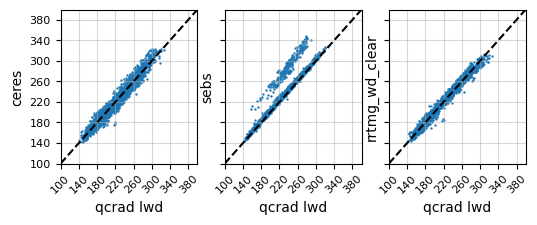

In [24]:
fig,ax=plt.subplots(1,3, sharey=True, figsize=(6,2))
ax00 = ax[0]
ax01 = ax[1]
ax02 = ax[2]

master_df_no_cloud = master_df[master_df.cloud_present < .1].dropna()
ax00.scatter( master_df_no_cloud['qcrad_lwd'], master_df_no_cloud['ceres_dlw_clear'], s=.5)
ax01.scatter( master_df_no_cloud['qcrad_lwd'], master_df_no_cloud['sebs_lw'],         s=.5)
ax02.scatter( master_df_no_cloud['qcrad_lwd'], master_df_no_cloud['rrtmg_lwd_clear'], s=.5)
lablist = ['ceres', 'sebs', 'rrtmg_wd_clear']

for i,axz in enumerate(ax.flatten()):
    axz.set_xlim(100, 400)
    axz.set_ylim(100, 400)
    axz.plot([100,400],[100,400], color='black', linestyle='--')
    axz.set_xlabel("qcrad lwd")
    axz.set_xticks(np.arange(100,400,40))
    axz.set_yticks(np.arange(100,400,40))
    axz.set_xticklabels(axz.get_xticks(), fontsize=8, rotation=45)
    axz.set_yticklabels(axz.get_xticks(), fontsize=8, rotation=0)
    axz.grid(alpha=.5)
    axz.set_ylabel(lablist[i])


In [25]:
master_df['cza'] = master_df.index.map(calculate_solar_cos_zenith)

Text(0.05, 0.8, '7.21')

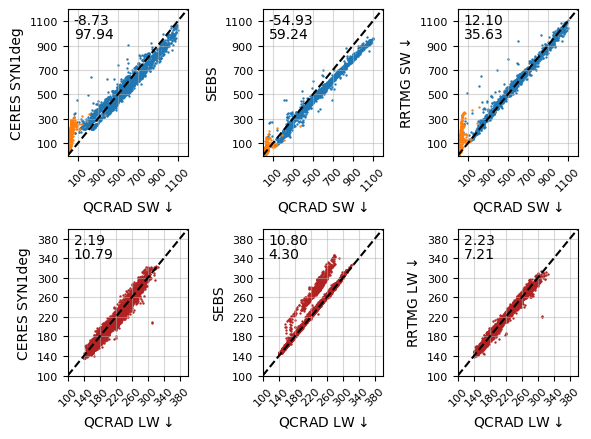

In [26]:
fig,ax=plt.subplots(2,3, figsize=(6, 4.5))
ax01 = ax[0, 0]
ax02 = ax[0, 1]
ax03 = ax[0, 2]


ax11 = ax[1, 0]
ax12 = ax[1, 1]
ax13 = ax[1, 2]



#### shortwave 
master_df_no_cloud_no_shadow = master_df[master_df.cloud_present < .01].where(master_df.shadow != 1).dropna()
#master_df_no_cloud_no_shadow = master_df_no_cloud_no_shadow[(master_df_no_cloud_no_shadow.qcrad_swd < master_df_no_cloud_no_shadow.cza * 1365)]
#master_df_no_cloud_no_shadow = master_df_no_cloud_no_shadow[(master_df_no_cloud_no_shadow.qcrad_swd > .5 * master_df_no_cloud_no_shadow.cza * 1365)]


master_df_no_cloud_no_shadow = master_df_no_cloud_no_shadow[~master_df_no_cloud_no_shadow.suli_qaqc.isin([['SC', 'SF - SC', 'SC - SF ']])]




ax01.scatter(master_df_no_cloud_no_shadow['qcrad_swd'], master_df_no_cloud_no_shadow['ceres_dsw_clear'], s=.5)
ax02.scatter(master_df_no_cloud_no_shadow['qcrad_swd'], master_df_no_cloud_no_shadow['sebs_sw'],         s=.5)
ax03.scatter(master_df_no_cloud_no_shadow['qcrad_swd'], master_df_no_cloud_no_shadow['rrtmg_swd_clear'], s=.5)

master_df_no_cloud_shadow = master_df[master_df.cloud_present < .01].where(master_df.shadow ==1).dropna()
ax01.scatter(master_df_no_cloud_shadow['qcrad_swd'], master_df_no_cloud_shadow['ceres_dsw_clear'], s=.5)
ax02.scatter(master_df_no_cloud_shadow['qcrad_swd'], master_df_no_cloud_shadow['sebs_sw'],         s=.5)
ax03.scatter(master_df_no_cloud_shadow['qcrad_swd'], master_df_no_cloud_shadow['rrtmg_swd_clear'], s=.5)

n_sw_to_keep = len(master_df_no_cloud['qcrad_lwd'].dropna())

lablist = ['CERES SYN1deg', 'SEBS', 'RRTMG SW$\downarrow$']
for i,axz in enumerate([ax01, ax02, ax03]):
    axz.set_xlim(0, 1200)
    axz.set_ylim(0, 1200)
    axz.plot([0,1200],[0,1200], color='black', linestyle='--')
    axz.set_xticks(np.arange(100,1200,200))
    axz.set_yticks(np.arange(100,1200,200))
    axz.set_xticklabels(axz.get_xticks(), fontsize=8, rotation=45)
    axz.set_yticklabels(axz.get_xticks(), fontsize=8, rotation=0)
    axz.set_xlabel(r"QCRAD SW$\downarrow$")
    axz.grid(alpha=.5)
    axz.set_ylabel(lablist[i])


## longwave 
master_df_no_cloud = master_df[master_df.cloud_present < .01]
n_lw_to_keep = len(master_df_no_cloud_no_shadow['qcrad_lwd'].dropna())

ax11.scatter( master_df_no_cloud['qcrad_lwd'], master_df_no_cloud['ceres_dlw_clear'], s=.5, color='firebrick')
ax12.scatter( master_df_no_cloud['qcrad_lwd'], master_df_no_cloud['sebs_lw'],         s=.5, color='firebrick')
ax13.scatter( master_df_no_cloud['qcrad_lwd'], master_df_no_cloud['rrtmg_lwd_clear'], s=.5, color='firebrick')
lablist = ['CERES SYN1deg', 'SEBS', r'RRTMG LW$\downarrow$']

for i,axz in enumerate([ax11, ax12, ax13]):
    axz.set_xlim(100, 400)
    axz.set_ylim(100, 400)
    axz.plot([100,400],[100,400], color='black', linestyle='--')
    axz.set_xlabel(r"QCRAD LW$\downarrow$")
    axz.set_xticks(np.arange(100,400,40))
    axz.set_yticks(np.arange(100,400,40))
    axz.set_xticklabels(axz.get_xticks(), fontsize=8, rotation=45)
    axz.set_yticklabels(axz.get_xticks(), fontsize=8, rotation=0)
    axz.grid(alpha=.5)
    axz.set_ylabel(lablist[i])

plt.tight_layout()


def compute_bias(df, var1, var2):
    return df[var1] - df[var2]

def iqrfx(df, var1, var2):
    data = df[var1] - df[var2]
    return np.percentile(data, 75) - np.percentile(data, 25)


ax[0,0].text(0.05, 0.9, f"{compute_bias(master_df_no_cloud_no_shadow, 'ceres_dsw_clear', 'qcrad_swd').mean():.2f}", transform=ax[0,0].transAxes)
ax[0,1].text(0.05, 0.9, f"{compute_bias(master_df_no_cloud_no_shadow, 'sebs_sw', 'qcrad_swd').mean():.2f}", transform=ax[0,1].transAxes)
ax[0,2].text(0.05, 0.9, f"{compute_bias(master_df_no_cloud_no_shadow, 'rrtmg_swd_clear', 'qcrad_swd').mean():.2f}", transform=ax[0,2].transAxes)


ax[0,0].text(0.05, 0.8, f"{iqrfx(master_df_no_cloud_no_shadow, 'ceres_dsw_clear', 'qcrad_swd').mean():.2f}", transform=ax[0,0].transAxes)
ax[0,1].text(0.05, 0.8, f"{iqrfx(master_df_no_cloud_no_shadow, 'sebs_sw', 'qcrad_swd').mean():.2f}", transform=ax[0,1].transAxes)
ax[0,2].text(0.05, 0.8, f"{iqrfx(master_df_no_cloud_no_shadow, 'rrtmg_swd_clear', 'qcrad_swd').mean():.2f}", transform=ax[0,2].transAxes)


ax[1,0].text(0.05, 0.9, f"{compute_bias(master_df_no_cloud_no_shadow, 'ceres_dlw_clear', 'qcrad_lwd').mean():.2f}", transform=ax[1,0].transAxes)
ax[1,1].text(0.05, 0.9, f"{compute_bias(master_df_no_cloud_no_shadow, 'sebs_lw', 'qcrad_lwd').mean():.2f}",         transform=ax[1,1].transAxes)
ax[1,2].text(0.05, 0.9, f"{compute_bias(master_df_no_cloud_no_shadow, 'rrtmg_lwd_clear', 'qcrad_lwd').mean():.2f}", transform=ax[1,2].transAxes)

ax[1,0].text(0.05, 0.8, f"{iqrfx(master_df_no_cloud_no_shadow, 'ceres_dlw_clear', 'qcrad_lwd').mean():.2f}", transform=ax[1,0].transAxes)
ax[1,1].text(0.05, 0.8, f"{iqrfx(master_df_no_cloud_no_shadow, 'sebs_lw', 'qcrad_lwd').mean():.2f}",         transform=ax[1,1].transAxes)
ax[1,2].text(0.05, 0.8, f"{iqrfx(master_df_no_cloud_no_shadow, 'rrtmg_lwd_clear', 'qcrad_lwd').mean():.2f}", transform=ax[1,2].transAxes)



In [19]:
#master_df['rrtmg_swd_clear'] = swdcdf['swd'].reindex(master_df.index)

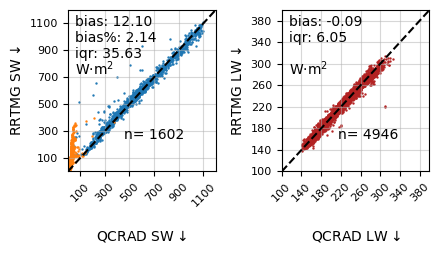

In [31]:
fig,ax=plt.subplots(1, 2, figsize=(4.5,2.5))

axz = ax[0]
#### shortwave 
master_df_no_cloud_no_shadow = master_df[master_df.cloud_present < .01].where(master_df.shadow != 1).dropna()

#master_df_no_cloud_no_shadow[


axz.scatter(master_df_no_cloud_no_shadow['qcrad_swd'], master_df_no_cloud_no_shadow['rrtmg_swd_clear'], s=.5, label='no shadow')
axz.scatter(master_df_no_cloud_shadow['qcrad_swd'], master_df_no_cloud_shadow['rrtmg_swd_clear'], s=.5, label='shadow')

n_sw_to_keep = len(master_df_no_cloud_no_shadow['qcrad_lwd'].dropna())
#lablist = ['CERES SYN1deg', 'SEBS', r'RRTMG SW$\downarrow$']
axz.set_xlim(0, 1200)
axz.set_ylim(0, 1200)
axz.plot([0,1200],[0,1200], color='black', linestyle='--')
axz.set_xticks(np.arange(100,1200,200))
axz.set_yticks(np.arange(100,1200,200))
axz.set_xticklabels(axz.get_xticks(), fontsize=8, rotation=45)
axz.set_yticklabels(axz.get_xticks(), fontsize=8, rotation=0)
axz.set_xlabel(r"QCRAD SW$\downarrow$")
axz.grid(alpha=.5)
axz.set_ylabel(r'RRTMG SW$\downarrow$')


## longwave 
master_df_no_cloud = master_df[master_df.cloud_present < .01]
n_lw_to_keep = len(master_df_no_cloud['qcrad_lwd'].dropna())

axk = ax[1]
axk.scatter( master_df_no_cloud['qcrad_lwd'], master_df_no_cloud['rrtmg_lwd_clear'], s=.5, color='firebrick')

axk.set_xlim(100, 400)
axk.set_ylim(100, 400)
axk.plot([100,400],[100,400], color='black', linestyle='--')
axk.set_xlabel(r"QCRAD LW$\downarrow$")
axk.set_xticks(np.arange(100,400,40))
axk.set_yticks(np.arange(100,400,40))
axk.set_xticklabels(axk.get_xticks(), fontsize=8, rotation=45)
axk.set_yticklabels(axk.get_xticks(), fontsize=8, rotation=0)
axk.grid(alpha=.5)
axk.set_ylabel(r'RRTMG LW$\downarrow$')
plt.tight_layout()


def compute_bias(df, var1, var2):
    return df[var1] - df[var2]

def compute_biasp(df, var1, var2):
    return (df[var1] - df[var2]).mean()/df[var2].mean() * 100


def iqrfx(df, var1, var2):
    data = df[var1] - df[var2]
    data = data.dropna()
    return np.percentile(data, 75) - np.percentile(data, 25)


axz.text(0.05, 0.9, f"bias: {compute_bias(master_df_no_cloud_no_shadow, 'rrtmg_swd_clear', 'qcrad_swd').mean():.2f}", transform=axz.transAxes)
axz.text(0.05, 0.8, f"bias%: {compute_biasp(master_df_no_cloud_no_shadow, 'rrtmg_swd_clear', 'qcrad_swd'):.2f}", transform=axz.transAxes)
axz.text(0.05, 0.7, f"iqr: {iqrfx(master_df_no_cloud_no_shadow, 'rrtmg_swd_clear', 'qcrad_swd').mean():.2f}", transform=axz.transAxes)
axz.text(0.05, 0.6, r"W$\cdot$m$^2$", transform=axz.transAxes)
axz.text(0.38, 0.20, f"n= {n_sw_to_keep}", transform=axz.transAxes)


axk.text(0.05, 0.9, f"bias: {compute_bias(master_df_no_cloud, 'rrtmg_lwd_clear', 'qcrad_lwd').mean():.2f}", transform=axk.transAxes)
axk.text(0.05, 0.8, f"iqr: {iqrfx(master_df_no_cloud, 'rrtmg_lwd_clear', 'qcrad_lwd').mean():.2f}", transform=axk.transAxes)
axk.text(0.05, 0.6, r"W$\cdot$m$^2$", transform=axk.transAxes)
axk.text(0.38, 0.20, f"n= {n_lw_to_keep}", transform=axk.transAxes)


labely = -0.35  # axes coords
for j in range(2):
    ax[j].xaxis.set_label_coords(0.5, labely)

plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/FigureX_radiation_validation", dpi=300,  bbox_inches="tight")







In [41]:
plt.scatter(master_df.qcrad_swd, master_df.qcrad_swd2, s=1)
plt.plot([0, 1200], [0, 1200], color='black', linestyle='--')

AttributeError: 'DataFrame' object has no attribute 'qcrad_swd2'

### compare the ... 
master_df['swd_2']

In [2]:
qcrad = xr.open_mfdataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/qcrad/*cdf")
# diffuse_hemisph = qcrad.down_short_diffuse_hemisp.where(qcrad.qc_down_short_diffuse_hemisp==0).to_pandas().resample("1h").mean()
# dir_normal = qcrad.short_direct_normal.where(qcrad.qc_short_direct_normal==0).to_pandas().resample("1h").mean()
# dsw_alt = master_df.cza * dir_normal + diffuse_hemisph
# master_df['qcrad_swd2'] = dsw_alt

In [7]:
cza = np.cos(np.deg2rad(qcrad.zenith)).to_pandas()

In [73]:
cza.resample("1h").interpolate().to_csv('~/gshare2/will_data/crf_files/qcrad_cza_1h.csv')

In [82]:
gsw2 = qcrad.down_short_diffuse_hemisp + qcrad.short_direct_normal * np.cos(qcrad.zenith)

In [119]:
qcr_za = np.deg2rad(qcrad.zenith.to_pandas())

In [134]:
qcr_cza = np.cos(qcr_za).resample("1h").interpolate().clip(lower=0)
master_df['cza_2'] = qcr_cza.reindex(master_df.index)

In [116]:
master_df.cza[0:100].clip(lower=0).plot()


<AxesSubplot: xlabel='time'>

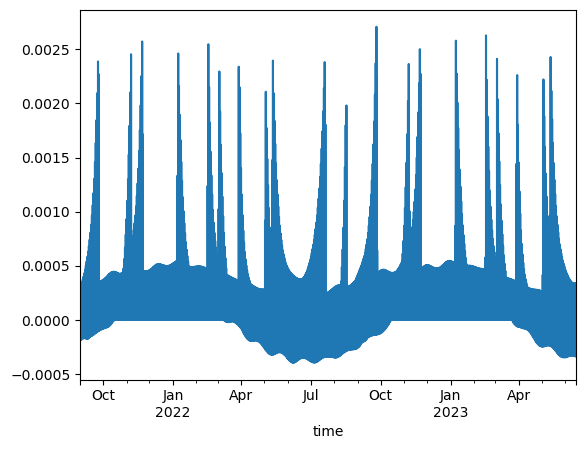

In [139]:
(master_df.cza_2- master_df.cza.clip(lower=0)).plot()
#master_df.cza[0:100].clip(lower=0).plot()

In [140]:
gsw2=(qcrad.short_direct_normal*np.cos(qcr_za).clip(lower=0) + qcrad.down_short_diffuse_hemisp).to_pandas()

In [146]:
gsw2.resample("1h").interpolate().where(master_df.cza_2 >0).mean()

401.16898

In [147]:
gsw1.resample("1h").interpolate().where(master_df.cza_2 >0).mean()

389.57037

In [ ]:
qcrad_cza = pd.read_csv('~/gshare2/will_data/crf_files/qcrad_cza_10min.csv', index_col=0, parse_dates=True)

In [53]:
dfx=pd.read_csv("~/gshare2/will_data/crf_files/rrtmgClearSkySW_and_M1Obs_SailPeriod_all_o3_ceresAer_0718_2.csv", index_col=0, parse_dates=True)



In [55]:
dfx.where(master_df.cza>0).swd.mean()

507.5003651012657

In [56]:
swdcdf17.resample("1h").interpolate().swd.where(master_df.cza > 0).mean()

512.9784580526515